<H3> Astrometry quality checks </H3>

The idea is to compute the distribution of the angular distances between matched sources from a set of exposures covering the same area. We arbitrarily take the first exposure as a reference.

The angular distance is computed:
<OL>
<LI> using the source coordinates associated to the "src" catalog, thus corresponding to the standard astrometric solution (fit using an external reference catalog only)</LI>
<LI> using the updated WCS from the simultaneous astrometry fit</LI>
</OL>

In [36]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import numpy as np
import math

# List of visits to be considered
#visits = [845346, 849375, 852894, 906675, 996234]
visits = [742765, 784811, 797092, 850070, 853092, 896072, 906804, 906889, 967979, 994926]
#visits = [742765, 784811, 797092]


# Reference visit
ref = 742765

# Tract
tract = 0

# List of CCD to be considered (source calatlogs will be concateneted)
ccd = [12, 13, 14, 21, 22, 23]
#ccd = [0, 1, 7, 8, 27, 28, 34, 35]
#ccd = [21, 22, 27, 28]
#ccd = [14]

filter = 'u'

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", "base_CircularApertureFlux_4_5_flag", "base_SdssCentroid_flag", 
         "base_SdssShape_flag"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/D3/output/coadd_dir")
    
calibRef = [None]*36
oldWcsRef = [None]*36
newWcsRef = [None]*36

for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    oldSrc = butler.get('src', dataid, immediate=True)
    print c, len(oldSrc)
    if indx == 0 :
        # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
        oldSchema = oldSrc.getSchema()
        mapper = afwTable.SchemaMapper(oldSchema)
        mapper.addMinimalSchema(oldSchema)
        newSchema = mapper.getOutputSchema()
        newSchema.addField("ccd", type=int, doc="CCD number")

        #create the new extented source catalog 
        srcRef = afwTable.SourceCatalog(newSchema)
        srcRef.reserve(1000000)

    # create temporary catalog
    tmpCat = afwTable.SourceCatalog(srcRef.table)
    tmpCat.extend(oldSrc, mapper=mapper)
    # fill in the ccd information in numpy mode in order to be efficient
    tmpCat['ccd'][:] = c
    # append the temporary catalog to the extended source catalog    
    srcRef.extend(tmpCat, deep=False)
        
    # retrieve the calibration object associated to the CCDs
    mdRef = butler.get("calexp_md", dataid, immediate=True)
    calibRef[c] =afwImage.Calib(mdRef)
        
    # retrieve the original and improved wcs
    oldWcsRef[c] = afwImage.TanWcs.cast(afwImage.makeWcs(mdRef))
    dataidNew = {'visit':ref, 'filter':filter, 'ccd':c, 'tract':tract}
    newWcsRefCont = butler.get('wcs', dataidNew, immediate=True)
    newWcsRef[c] = afwImage.TanWcs.cast(newWcsRefCont.getWcs())

print "Ref...", len(srcRef)
    
# Store original and updated Wcs associated to each visit / ccd
oldWcsVis = {}
newWcsVis = {}
for v in visits :
    oldWcsVis[v] = [None]*36
    newWcsVis[v] = [None]*36
    for c in ccd :
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        dataidNew = {'visit':v, 'filter':filter, 'ccd':c, 'tract':tract}
        mdVis = butler.get("calexp_md", dataid, immediate=True)
        oldWcsVis[v][c] = afwImage.TanWcs.cast(afwImage.makeWcs(mdVis))
        newWcsVisCont = butler.get('wcs', dataidNew, immediate=True)
        newWcsVis[v][c] = afwImage.TanWcs.cast(newWcsVisCont.getWcs())

mag = []
oldDist = []
newDist = []
xSig = []
ff = 0
for indV, v in enumerate(visits) :
    if v == ref :
        continue
    if ff == 0 :
        ff = 1
    for indC, c in enumerate(ccd) :
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        src = butler.get('src', dataid, immediate=True)

        match = afwTable.matchRaDec(srcRef, src, afwGeom.Angle(1./3600., afwGeom.degrees))

        schemaRef = srcRef.getSchema()
        if ff == 1 and indC == 0 :
            ff = 2
            schemaSrc = src.getSchema()
            flagKeyRef = []
            flagKeyVis = []
            for f in Flags :
                keyRef = schemaRef[f].asKey()
                flagKeyRef.append(keyRef)
                keyVis = schemaSrc[f].asKey()
                flagKeyVis.append(keyVis)

            extendKey = newSchema["base_ClassificationExtendedness_value"].asKey()
            fluxKey = newSchema["base_CircularApertureFlux_4_5_flux"].asKey()
            fluxSigmaKey = newSchema["base_CircularApertureFlux_4_5_fluxSigma"].asKey()
            ccdKeyRef = newSchema["ccd"].asKey()
            
            xSigmaKey = schemaSrc["base_SdssCentroid_xSigma"].asKey()
            ySigmaKey = schemaSrc["base_SdssCentroid_ySigma"].asKey()
            mxxKey = schemaSrc["base_SdssShape_xx"].asKey()
            myyKey = schemaSrc["base_SdssShape_yy"].asKey()
            mxyKey = schemaSrc["base_SdssShape_xy"].asKey()              

        for m in match :
            mRef = m.first
            mVis = m.second

            for f in flagKeyRef :
                rej = 0
                if mRef.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                    continue
            for f in flagKeyVis :
                rej = 0
                if mVis.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                    continue
                    
            # cleanup the reference sources in order to keep only decent star-like objects
            if mRef.get(extendKey) >= 0.5 :
                continue

            ang = afwGeom.radToMas(m.distance)

            # retrieve the CCD corresponding to the reference source
            ccdRef = mRef.get(ccdKeyRef)
            ccdVis = c

            # compute magnitude
            calib = calibRef[ccdRef]
            flux = mRef.get(fluxKey)
            fluxSigma = mRef.get(fluxSigmaKey)
            if flux /fluxSigma < 5 :
                continue
            if flux > 0. :
                refMag = calib.getMagnitude(flux)
            else :
                continue
            if refMag < 16.5 or refMag > 26 :
                continue

            footprint = mVis.getFootprint()
            if footprint is not None and len(footprint.getPeaks()) > 1 :
                continue
                
            # Check consistency of the source covariance parameters
            vx = np.square(mVis.get(xSigmaKey))
            vy = np.square(mVis.get(ySigmaKey))
            mxx = mVis.get(mxxKey)
            myy = mVis.get(myyKey)
            mxy = mVis.get(mxyKey)
            vxy = mxy*(vx+vy)/(mxx+myy)
            if (vxy*vxy)>(vx*vy) or np.isnan(vx) or np.isnan(vy):
                print "Error in covariance : ", v, c, ccdRef, vxy*vxy, vx*vy, vx, vy, mVis.get("base_SdssCentroid_flag"), mVis.get("base_SdssShape_flag")
                print mVis.get(xSigmaKey), mVis.get(ySigmaKey), mxx, myy, mxy
                print mVis.get("base_SdssCentroid_x"), mVis.get("base_SdssCentroid_y")
                continue

            oldCoordRef = mRef.getCoord()
            pixelsRef = oldWcsRef[ccdRef].skyToPixel(oldCoordRef.getRa(), oldCoordRef.getDec())
            newCoordRef = newWcsRef[ccdRef].pixelToSky(pixelsRef).toIcrs()

            oldCoordVis = mVis.getCoord()
            pixelsVis = oldWcsVis[v][c].skyToPixel(oldCoordVis.getRa(), oldCoordVis.getDec())
            newCoordVis = newWcsVis[v][c].pixelToSky(pixelsVis).toIcrs()

            newAngle = 1000.0*newCoordRef.angularSeparation(newCoordVis).asArcseconds()       

            mag.append(refMag)
            oldDist.append(ang)
            newDist.append(newAngle)
            xSig.append(mVis.get(xSigmaKey))

            if refMag<20 and newAngle>400 :
                print v, newAngle, refMag, ccdRef, ccdVis, mRef.getCoord(), newCoordVis, mVis.get(xSigmaKey), mVis.get(ySigmaKey)

12 1687
13 1763
14 1722
21 1927
22 1726
23 1756
Ref... 10581
Error in covariance :  850070 13 13 25.9357650314 17.4077826462 0.370592510359 46.9728398703 False False
0.608763098717 6.8536734581 5.08332664063 11.1358903683 -1.74469563756
1702.34669056 1944.82247561
Error in covariance :  850070 21 21 0.0117880799611 0.00916505278424 0.35913316042 0.0255199290801 False False
0.599277198315 0.15974958241 11.4025788309 25.0872315806 10.2996844259
1391.29821362 350.039444656
Error in covariance :  896072 13 13 0.215636966427 0.142570210545 0.14543051279 0.980332172457 False False
0.381353527308 0.990117251873 31.9735340835 76.4061496894 -44.7056729786
1886.37310165 2384.55877533
896072 2644.34540195 19.4735014895 14 14 IcrsCoord(214.6960281, 52.9064146) IcrsCoord(214.6957858, 52.9056977) 0.0110625242814 0.0123153002933
906804 179553.408073 16.7726547238 14 14 IcrsCoord(214.7235056, 52.8399035) IcrsCoord(214.7830809, 52.8054614) 0.00239214347675 0.00295085366815
906804 179553.414076 16.77265

### Plot results for the standard astrometric solution (fit source coordinates to an external reference catalog only)

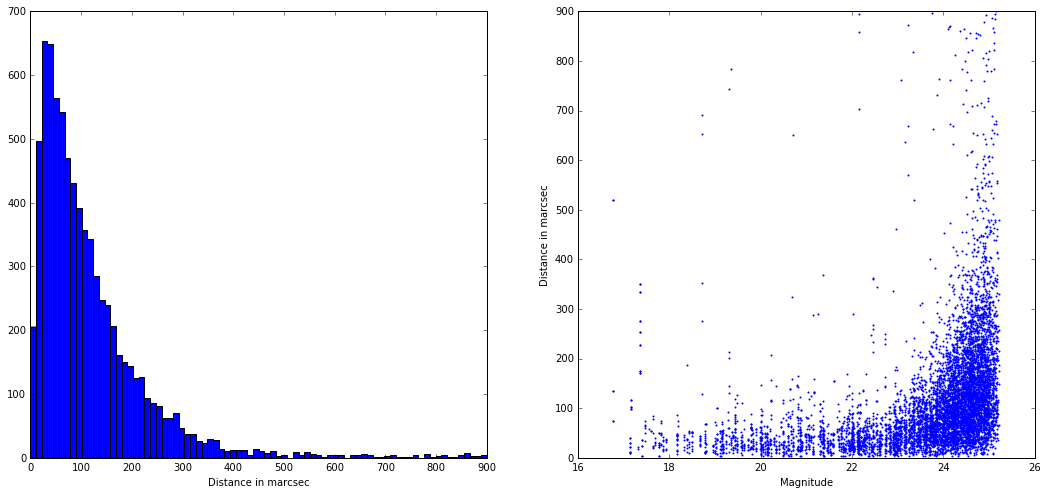

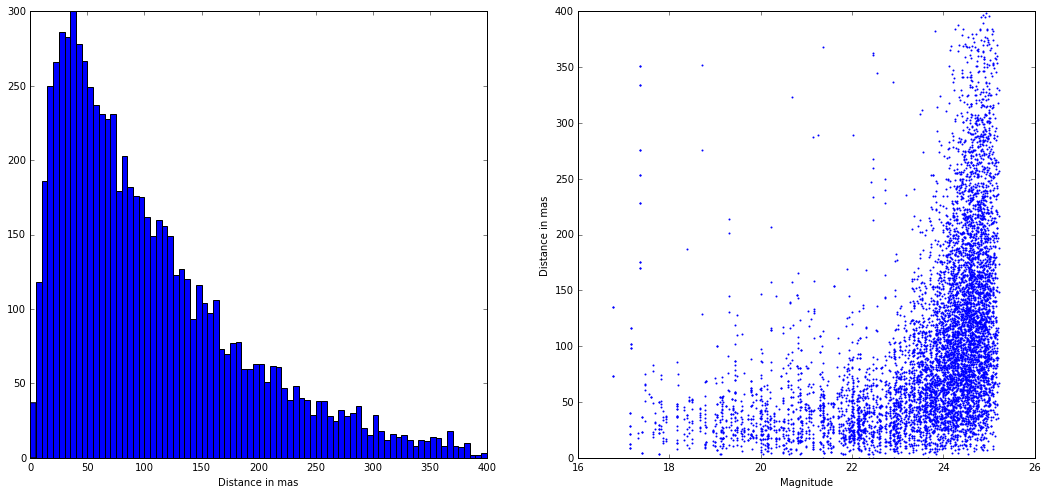

Median value of the astrometric scatter : 86.3070103265 mas


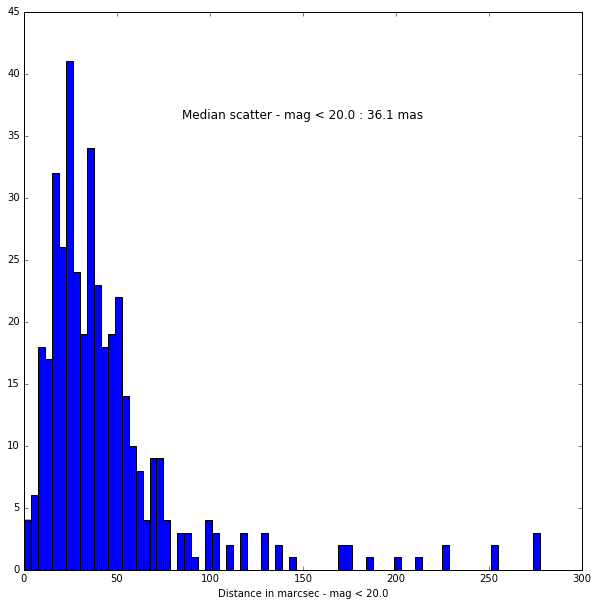

Median scatter - mag < 20.0 : 36.1 mas


In [37]:

%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist, bins=80, range=[0.,900.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist,bins=80, range=[0.,400.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(oldDist), "mas"

magLim = 20
idxs = np.where(np.asarray(mag) < magLim)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(oldDist)[idxs], bins=80, range=[0., 300.])
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])),x=0.5, y=0.8)
plt.show()

print "Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs]))

### Plot results for astrometric solution from the simultaneous fit

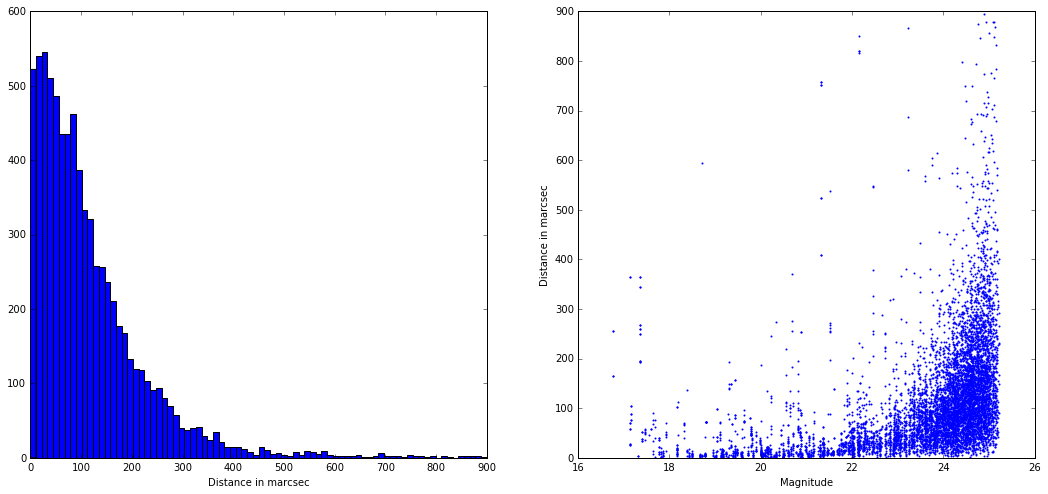

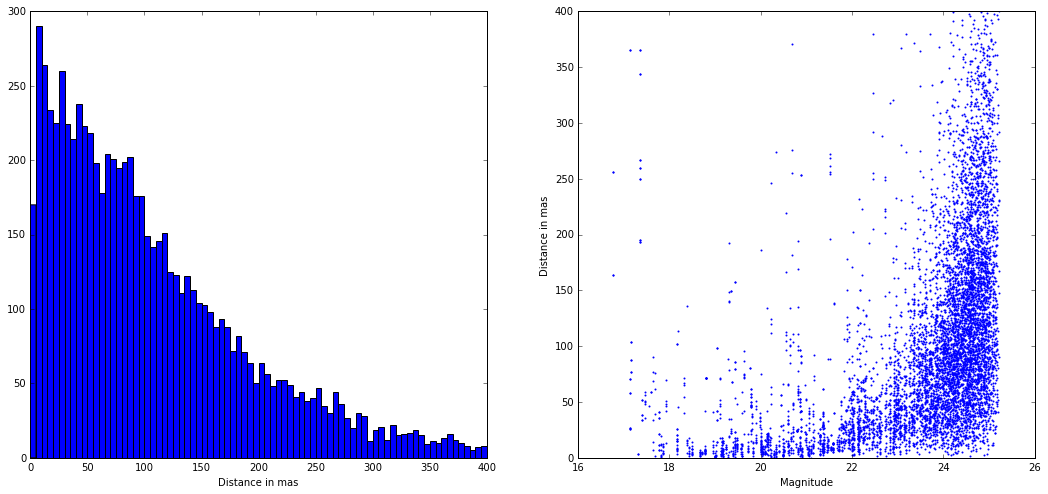

Median value of the astrometric scatter : 88.4646530099 mas


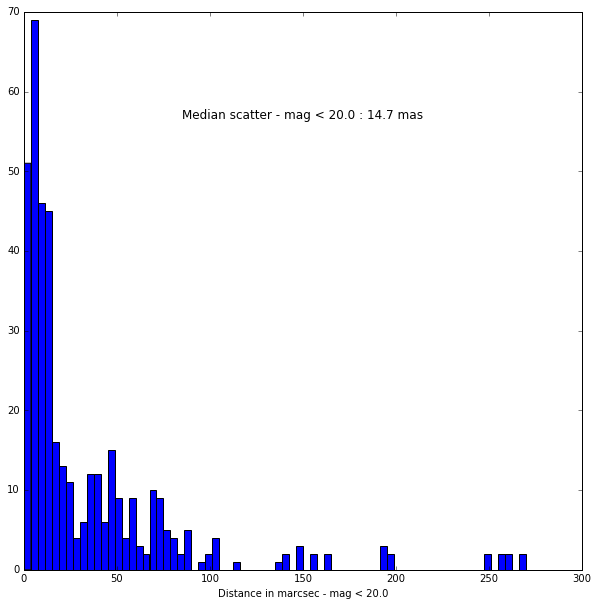

Astrometric scatter (median) - mag < 20.0 : 14.7 mas


In [38]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist, bins=80, range=[0., 900.])
ax1.scatter(mag, newDist, s=1, color='b')
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist,bins=80, range=[0., 400.])
ax0.set_xlim([0.,400.])
ax1.scatter(mag, newDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(newDist), "mas"

magLim = 20
idxs = np.where(np.asarray(mag) < magLim)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs], bins=80, range=[0., 300.])
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])),x=0.5, y=0.8)
plt.show()

print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs]))

In [7]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

dataid = {'visit':906889, 'filter':'u', 'ccd':10}
dataid2 = {'visit':906889, 'filter':'u', 'ccd':10, 'tract':0 }

butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/D3/output/coadd_dir")

exp = butler.get('calexp', dataid2, immediate=True)
wcsCont = butler.get('wcs', dataid2, immediate=True)
newWcs = afwImage.TanWcs.cast(wcsCont.getWcs())
src = butler.get('src', dataid, immediate=True)

md = butler.get("calexp_md",dataid, immediate=True)
oldWcs = afwImage.TanWcs.cast(afwImage.makeWcs(md))

oldCoord = src[10].getCoord()
print oldCoord.getRa(), oldCoord.getDec()
oldRa = src[10].getRa()
oldDec = src[10].getDec()
print "old Coord", oldCoord

pixels = oldWcs.skyToPixel(oldCoord)
cc = oldWcs.pixelToSky(pixels).toIcrs()
print "Coord with reverse transformation - old WCS", cc
print "pixels with old wcs", pixels
newCoord = newWcs.pixelToSky(pixels).toIcrs()
newPixels = newWcs.skyToPixel(newCoord)
print "pixels with new wcs", newPixels
print newCoord
print

point = afwGeom.Point2D(100., 200.)
newCoord = newWcs.pixelToSky(point)
pointCheck = newWcs.skyToPixel(newCoord)

print "Verif new wcs - Point", point, "should be equal to ", pointCheck

point = afwGeom.Point2D(100., 200.)
oldCoord = oldWcs.pixelToSky(point)
pointCheck = oldWcs.skyToPixel(oldCoord)

print "Verif old wcs - Point", point, "should be equal to ", pointCheck

3.75815 rad 0.923123 rad
old Coord IcrsCoord(215.3260456, 52.8910770)
Coord with reverse transformation - old WCS IcrsCoord(215.3260456, 52.8910770)
pixels with old wcs (7.9999, 62)
pixels with new wcs (7.9999, 62)
IcrsCoord(215.3259804, 52.8910860)

Verif new wcs - Point (100, 200) should be equal to  (100, 200)
Verif old wcs - Point (100, 200) should be equal to  (100, 200)


In [10]:
print src.getSchema().getOrderedNames()
print src[10].get("coord_ra"), src[10].get("coord_dec")
print dir(src[10])

('id', 'coord_ra', 'coord_dec', 'parent', 'flags_negative', 'base_GaussianCentroid_x', 'base_GaussianCentroid_y', 'base_GaussianCentroid_flag', 'base_GaussianCentroid_flag_noPeak', 'base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts', 'base_NaiveCentroid_flag_edge', 'base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma', 'base_SdssCentroid_flag', 'base_SdssCentroid_flag_edge', 'base_SdssCentroid_flag_noSecondDerivative', 'base_SdssCentroid_flag_almostNoSecondDerivative', 'base_SdssCentroid_flag_notAtMaximum', 'base_SdssShape_xx', 'base_SdssShape_yy', 'base_SdssShape_xy', 'base_SdssShape_xxSigma', 'base_SdssShape_yySigma', 'base_SdssShape_xySigma', 'base_SdssShape_x', 'base_SdssShape_y', 'base_SdssShape_flux', 'base_SdssShape_fluxSigma', 'base_SdssShape_flux_xx_Cov', 'base_SdssShape_flux_yy_Cov', 'base_SdssShape_flux_xy_Cov', 'base_SdssShape_flag', 'base_SdssShape_flag_unweightedBad', 

(array([  1.69800000e+03,   1.07400000e+03,   1.30300000e+03,
          1.21500000e+03,   8.00000000e+02,   5.27000000e+02,
          2.58000000e+02,   1.85000000e+02,   1.16000000e+02,
          1.16000000e+02,   7.90000000e+01,   6.80000000e+01,
          6.60000000e+01,   5.10000000e+01,   3.90000000e+01,
          3.10000000e+01,   2.70000000e+01,   1.30000000e+01,
          1.40000000e+01,   8.00000000e+00,   7.00000000e+00,
          6.00000000e+00,   5.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
        

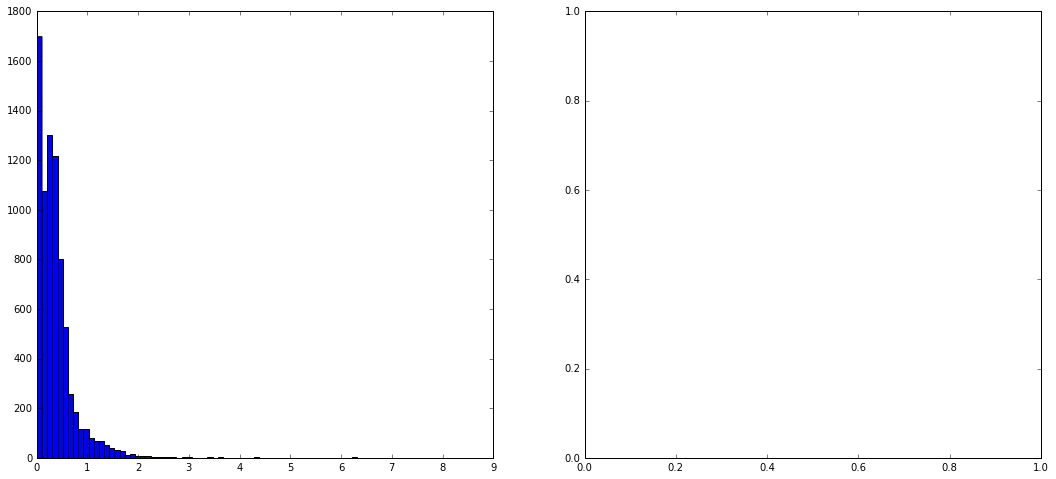

In [25]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(xSig, bins=80)